In [67]:
import numpy as np
import matplotlib.pyplot as plt
import particles
from particles import state_space_models as ssm
from scipy.stats import norm, t as student_t
from copula_models import StudentFactorCopulaSSM,GaussianFactorCopulaSSM, simulate_copula_model_particles
from copula_models_u import StudentFactorCopulaSSM_U,GaussianFactorCopulaSSM_U, simulate_copula_model_U
from scipy.stats import norm
from scipy.stats import t as student_t

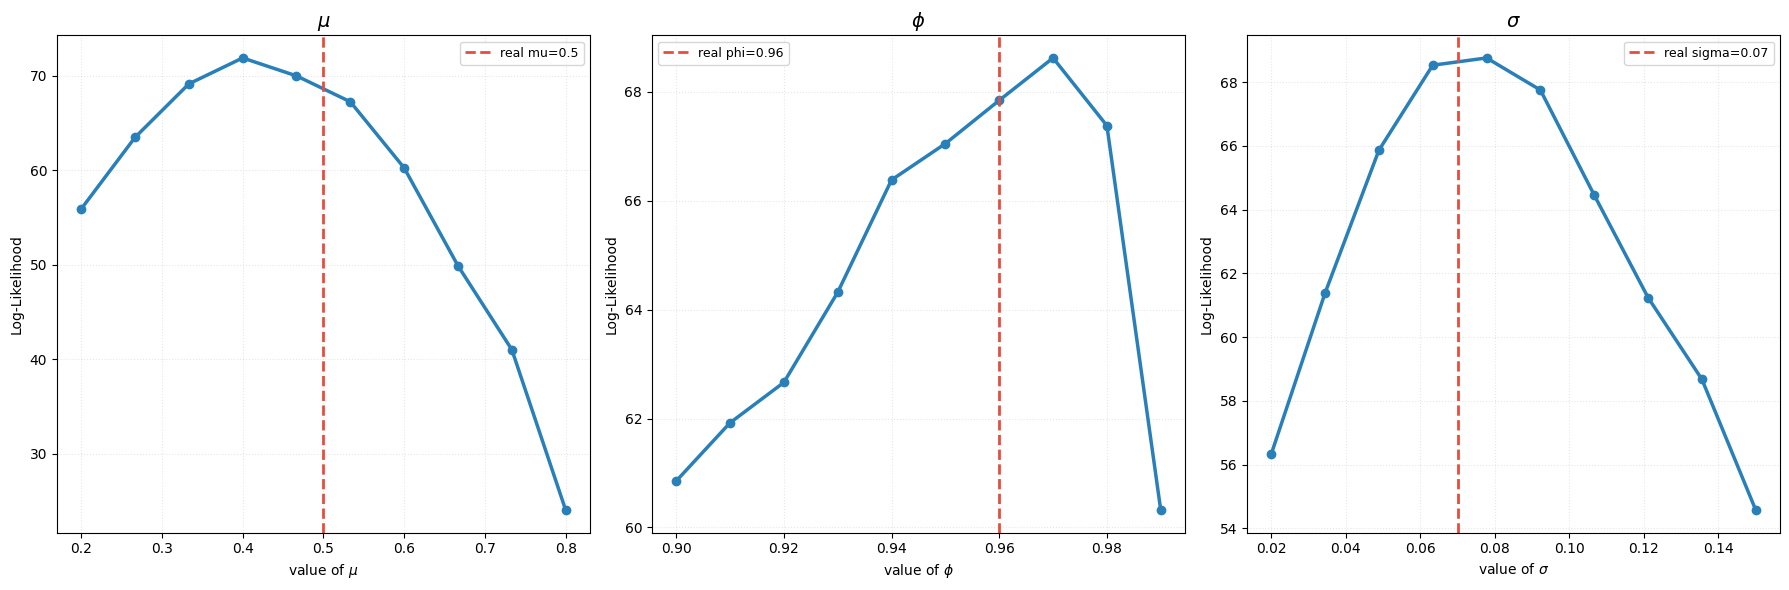

In [68]:
T, n_series, N_particles = 300, 10, 2000
true_params_gauss = {'mu': 0.5, 'phi': 0.96, 'sigma': 0.07}

model_gen = GaussianFactorCopulaSSM_U(n_series=n_series, n_factors=1, **true_params_gauss)
true_states, u_data = simulate_copula_model_U(model_gen, T)

# profil de vraissemblance
def get_ll_profile_gauss(param_name, test_value):
    current_p = {**true_params_gauss, 'n_series': n_series, 'n_factors': 1}
    current_p[param_name] = test_value
    
    # Appel du modèle Gaussien qui traite les uniformes u_t
    model_test = GaussianFactorCopulaSSM_U(**current_p)
    fk = ssm.Bootstrap(ssm=model_test, data=u_data)
    
    # Utilisation du filtre particulaire pour estimer la LL
    pf = particles.SMC(fk=fk, N=N_particles, verbose=False)
    pf.run()
    return pf.logLt


scenarios = {
    'mu':    (r'$\mu$', np.linspace(0.2, 0.8, 10)),
    'phi':   (r'$\phi$', np.linspace(0.90, 0.99, 10)),
    'sigma': (r'$\sigma$', np.linspace(0.02, 0.15, 10))
}

results = {}
for p_name, (label, vals) in scenarios.items():
    results[p_name] = [get_ll_profile_gauss(p_name, v) for v in vals]

# Plot des profils de vraissemblance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

for ax, (p_name, (label, vals)) in zip(axes, scenarios.items()):
    ax.plot(vals, results[p_name], 'o-', color='#2980b9', lw=2.5, ms=6)
    
    # Ligne verticale pour la vraie valeur
    ax.axvline(true_params_gauss[p_name], color='#e74c3c', ls='--', lw=2, 
               label=f'real {p_name}={true_params_gauss[p_name]}')
    
    ax.set_title(f"{label}", fontsize=14, fontweight='bold')
    ax.set_xlabel(f"value of {label}")
    ax.set_ylabel("Log-Likelihood")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

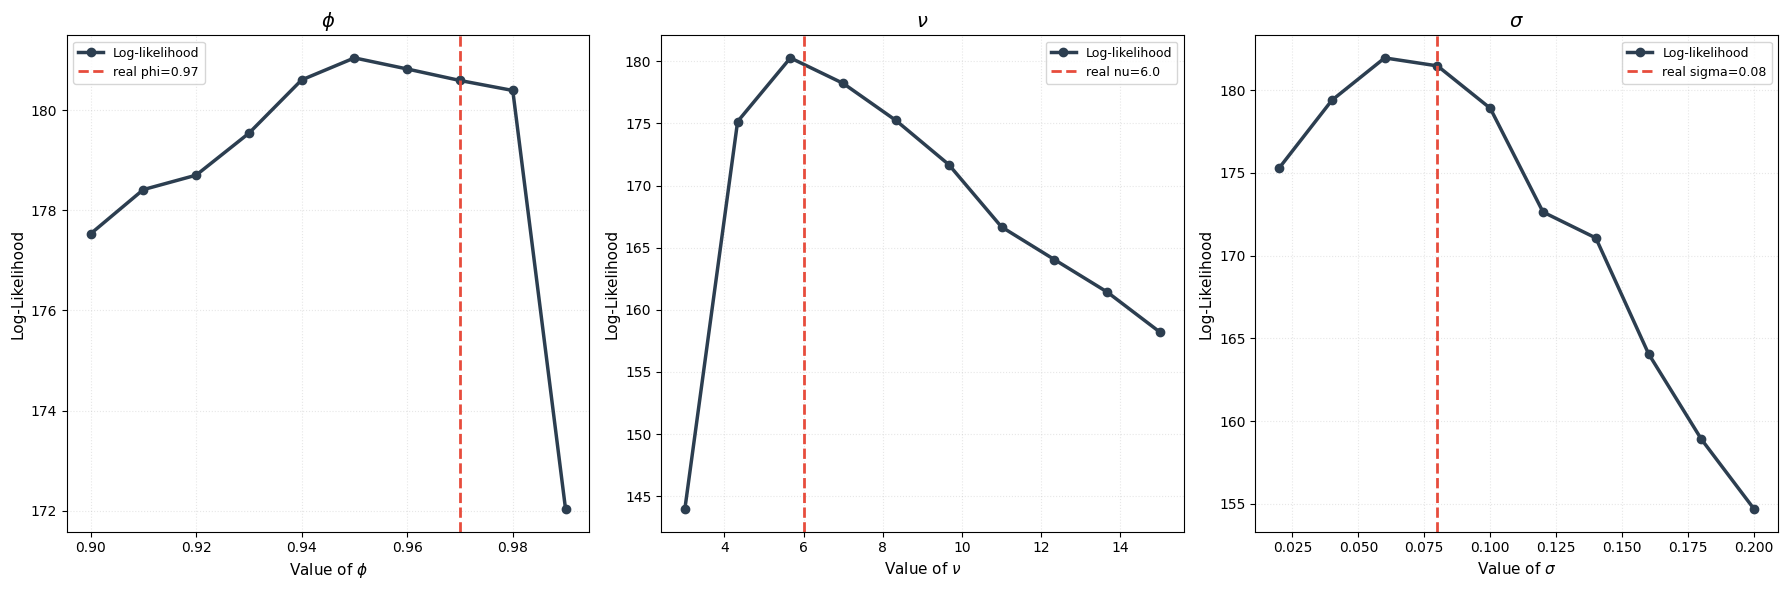

In [69]:
T, n_series, N_particles = 250, 10, 10000
true_params = {'mu': 0.4, 'phi': 0.97, 'sigma': 0.08, 'nu': 6.0}

model_gen = StudentFactorCopulaSSM_U(n_series=n_series, n_factors=1, **true_params)
true_states, u_data = simulate_copula_model_U(model_gen, T)

# --- 2. FONCTION DE PROFIL DE VRAISEMBLANCE ---
def get_ll_profile(param_name, test_value):
    current_p = {**true_params, 'n_series': n_series, 'n_factors': 1}
    current_p[param_name] = test_value
    model_test = StudentFactorCopulaSSM_U(**current_p)
    fk = ssm.Bootstrap(ssm=model_test, data=u_data)
    pf = particles.SMC(fk=fk, N=1500, verbose=False)
    pf.run()
    return pf.logLt

# --- 3. CALCUL DES SCÉNARIOS ---
scenarios = {
    'phi':   (r'$\phi$', np.linspace(0.90, 0.99, 10)),
    'nu':    (r'$\nu$', np.linspace(3, 15, 10)),
    'sigma': (r'$\sigma$', np.linspace(0.02, 0.20, 10))
}

results = {}
for p_name, (label, vals) in scenarios.items():
    results[p_name] = [get_ll_profile(p_name, v) for v in vals]

# subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

for ax, (p_name, (label, vals)) in zip(axes, scenarios.items()):
    # Plot des points calculés
    ax.plot(vals, results[p_name], 'o-', color='#2c3e50', lw=2.5, ms=6, label='Log-likelihood')
    
    # Ligne verticale pour la valeur réelle (cible)
    ax.axvline(true_params[p_name], color='#e74c3c', ls='--', lw=2, 
               label=f'real {p_name}={true_params[p_name]}')
    
    ax.set_title(f"{label}", fontsize=14, fontweight='bold')
    ax.set_xlabel(f"Value of {label}", fontsize=11)
    ax.set_ylabel("Log-Likelihood", fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

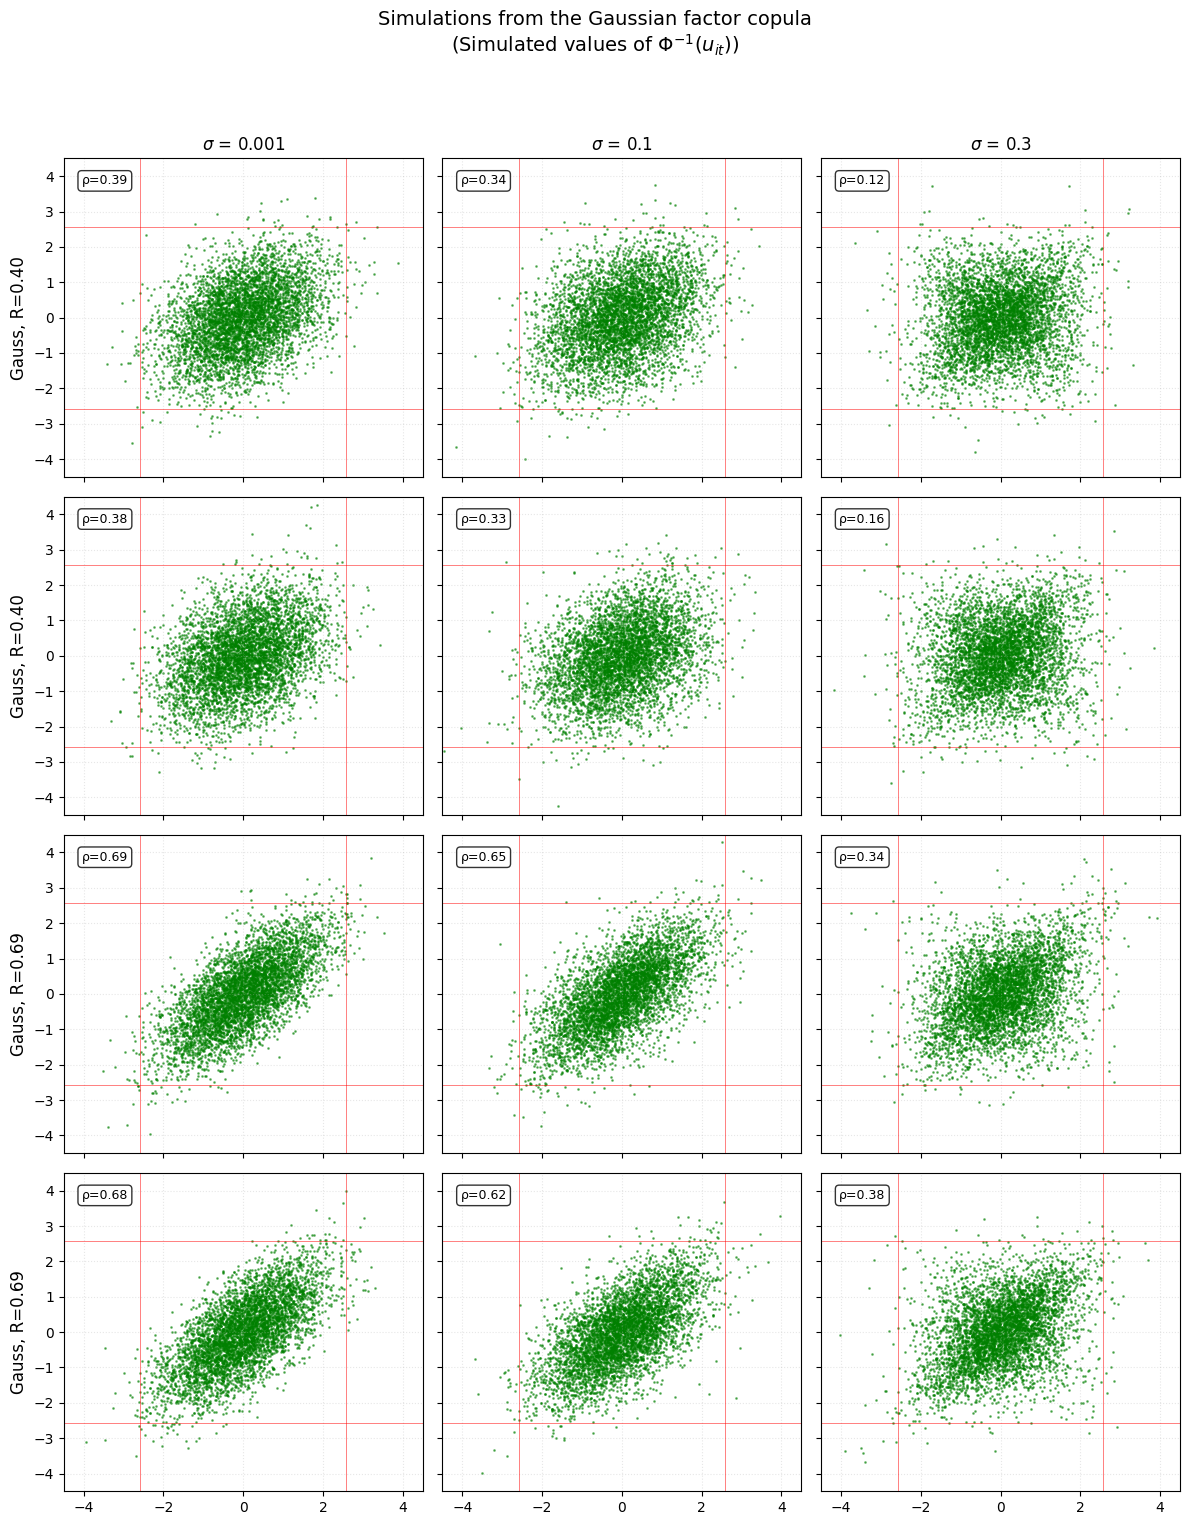

In [70]:
T = 5000
n_series = 2

# Colonnes : volatilité des loadings
sigmas = [0.001, 0.1, 0.3]

# Lignes : Corrélation cible R (Nu est ignoré ici car on est en Gaussien)
rows_params = [
    {'nu': 'Inf', 'R': 0.4},   
    {'nu': 'Inf', 'R': 0.4},   
    {'nu': 'Inf', 'R': 0.69},  
    {'nu': 'Inf', 'R': 0.69}
]

def correlation_to_loading(R):
    """Relation R = lambda^2 / (1 + lambda^2)"""
    return np.sqrt(R / (1 - R))

# Lignes de référence (quantiles 0.5% et 99.5%)
ref_lines = norm.ppf([0.005, 0.995])

fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)

for i, row_cfg in enumerate(rows_params):
    R = row_cfg['R']
    mu = correlation_to_loading(R)
    
    for j, sig in enumerate(sigmas):
        ax = axes[i, j]
        
        # 1. Création du modèle GAUSSIEN
        # Note : 'nu' n'est pas passé car la classe Gaussian ne l'utilise pas
        model = GaussianFactorCopulaSSM(
            n_series=n_series,
            n_factors=1,
            mu=mu,
            phi=0.98,
            sigma=sig
        )
        _, data = simulate_copula_model_particles(model, T)
        
        # Vers Uniforme (via CDF Normale)
        U = norm.cdf(data)
        U = np.clip(U, 1e-9, 1 - 1e-9)
        
        # Vers Quantiles Normaux (via Inverse Normale)
        X_norm = norm.ppf(U)
        
        # Plot Scatter
        ax.scatter(X_norm[:, 0], X_norm[:, 1], s=1, alpha=0.5, color='green') # Vert pour distinguer
        
        # Lignes de référence
        for ref in ref_lines:
            ax.axhline(ref, color='red', linewidth=0.5, alpha=0.7)
            ax.axvline(ref, color='red', linewidth=0.5, alpha=0.7)
        
        ax.set_xlim(-4.5, 4.5)
        ax.set_ylim(-4.5, 4.5)
        
        # Titres
        if i == 0:
            ax.set_title(f"$\sigma$ = {sig}", fontsize=12)
        if j == 0:
            ax.set_ylabel(f"Gauss, R={R:.2f}", fontsize=12)
        
        ax.grid(True, linestyle=':', alpha=0.3)
        
        # Corrélation empirique
        corr_emp = np.corrcoef(X_norm[:, 0], X_norm[:, 1])[0, 1]
        ax.text(0.05, 0.95, f"ρ={corr_emp:.2f}", transform=ax.transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle("Simulations from the Gaussian factor copula\n"
             "(Simulated values of $\Phi^{-1}(u_{it})$)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

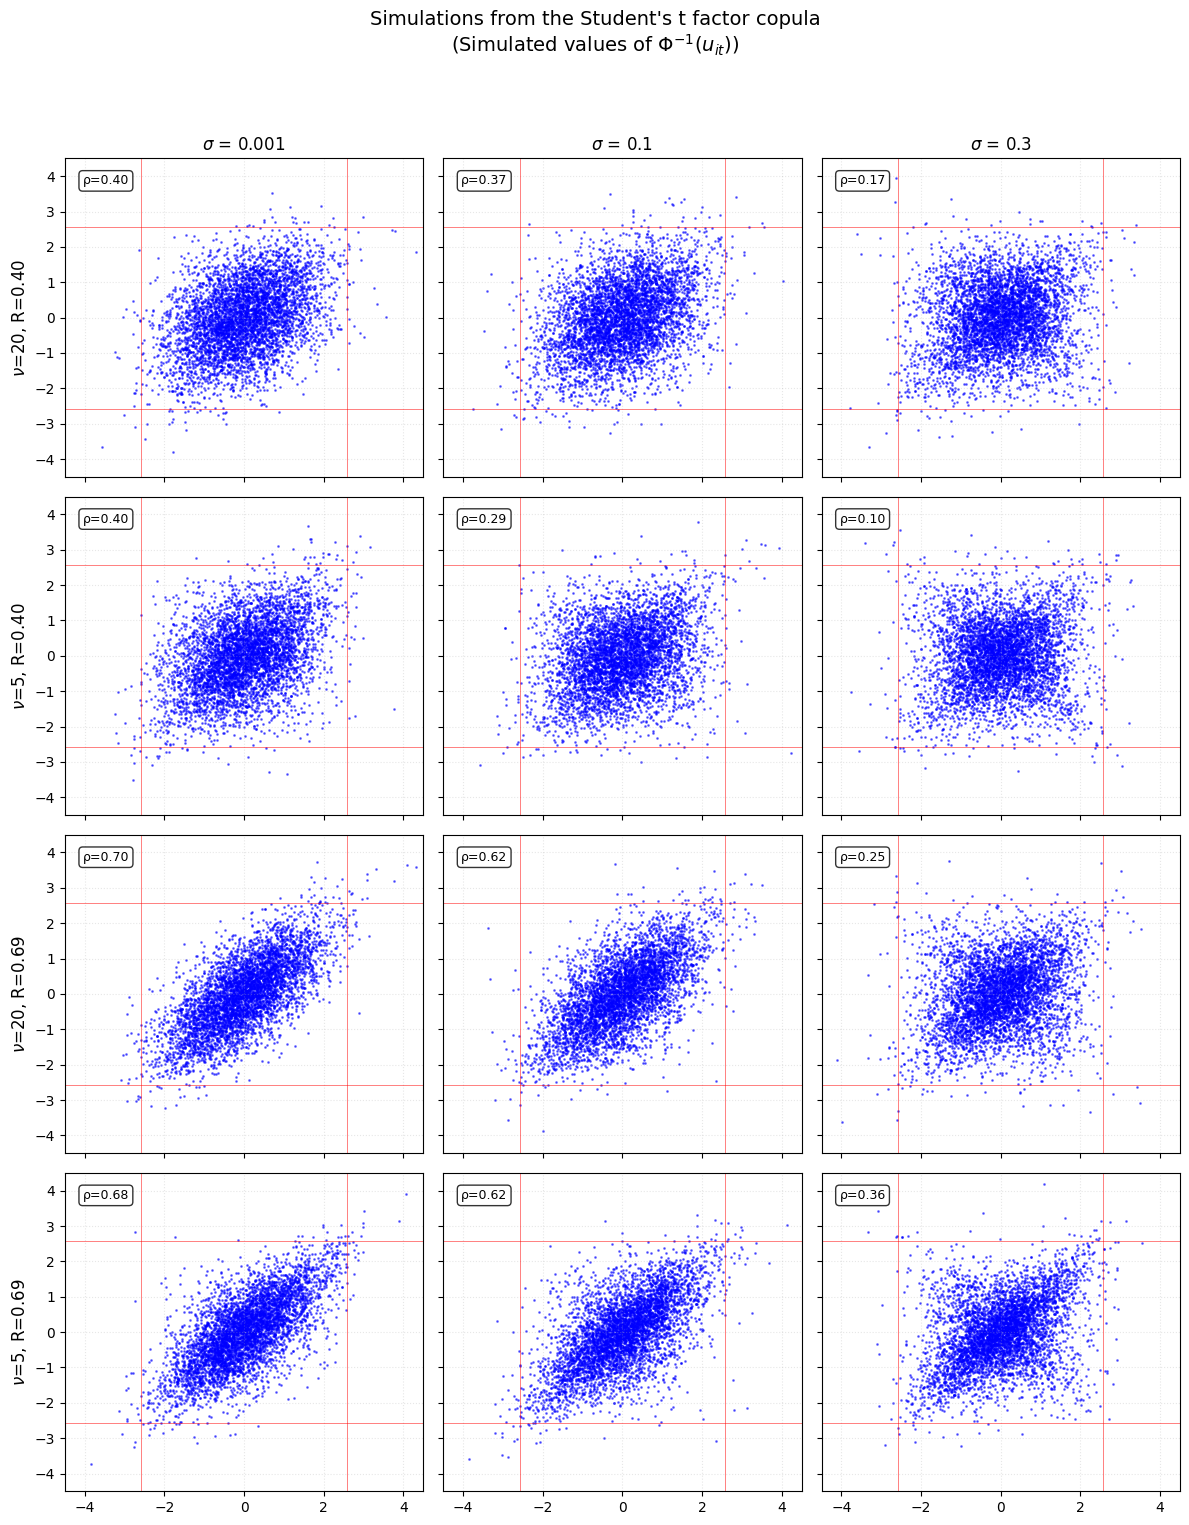

In [71]:
T = 5000
n_series = 2

# Colonnes : différentes valeurs de sigma (volatilité des loadings)
sigmas = [0.001, 0.1, 0.3]

# Lignes : combinaisons de (nu, R)
rows_params = [
    {'nu': 20, 'R': 0.4},   # Ligne 1
    {'nu': 5,  'R': 0.4},   # Ligne 2
    {'nu': 20, 'R': 0.69},  # Ligne 3
    {'nu': 5,  'R': 0.69}   # Ligne 4
]

def correlation_to_loading(R):
    """Convertit une corrélation cible en loading moyen."""
    return np.sqrt(R / (1 - R))

# Lignes de référence
ref_lines = norm.ppf([0.005, 0.995])

# Création de la figure
fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)

for i, row_cfg in enumerate(rows_params):
    nu = row_cfg['nu']
    R = row_cfg['R']
    mu = correlation_to_loading(R)
    
    for j, sig in enumerate(sigmas):
        ax = axes[i, j]
        
        # Création du modèle avec les paramètres appropriés
        model = StudentFactorCopulaSSM(
            n_series=n_series,
            n_factors=1,
            mu=mu,
            phi=0.98,        # Haute persistance comme dans l'article
            sigma=sig,
            nu=nu
        )
        
        # Simulation
        true_states, data = simulate_copula_model_particles(model, T)
        
        # CDF Student pour obtenir les uniformes
        U = student_t.cdf(data, df=nu)
        U = np.clip(U, 1e-9, 1 - 1e-9)
        
        # Inverse Normal pour obtenir Φ^{-1}(u)
        X_norm = norm.ppf(U)
        
        # Plot Scatter
        ax.scatter(X_norm[:, 0], X_norm[:, 1], s=1, alpha=0.5, color='blue')
        
        # Lignes de référence
        for ref in ref_lines:
            ax.axhline(ref, color='red', linewidth=0.5, alpha=0.7)
            ax.axvline(ref, color='red', linewidth=0.5, alpha=0.7)
        
        ax.set_xlim(-4.5, 4.5)
        ax.set_ylim(-4.5, 4.5)
        
        # Titres
        if i == 0:
            ax.set_title(f"$\sigma$ = {sig}", fontsize=12)
        if j == 0:
            ax.set_ylabel(f"$\\nu$={nu}, R={R:.2f}", fontsize=12)
        
        ax.grid(True, linestyle=':', alpha=0.3)
        
        # Calcul de la corrélation empirique pour vérification
        corr_emp = np.corrcoef(X_norm[:, 0], X_norm[:, 1])[0, 1]
        ax.text(0.05, 0.95, f"ρ={corr_emp:.2f}", transform=ax.transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle("Simulations from the Student's t factor copula\n"
             "(Simulated values of $\Phi^{-1}(u_{it})$)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Run 1/200 : Log-L = 49.30
Run 2/200 : Log-L = 49.77
Run 3/200 : Log-L = 49.62
Run 4/200 : Log-L = 49.74
Run 5/200 : Log-L = 49.33
Run 6/200 : Log-L = 49.31
Run 7/200 : Log-L = 49.74
Run 8/200 : Log-L = 49.27
Run 9/200 : Log-L = 49.51
Run 10/200 : Log-L = 49.25
Run 11/200 : Log-L = 49.25
Run 12/200 : Log-L = 49.60
Run 13/200 : Log-L = 49.19
Run 14/200 : Log-L = 49.64
Run 15/200 : Log-L = 49.58
Run 16/200 : Log-L = 49.26
Run 17/200 : Log-L = 49.78
Run 18/200 : Log-L = 49.42
Run 19/200 : Log-L = 49.64
Run 20/200 : Log-L = 48.88
Run 21/200 : Log-L = 49.39
Run 22/200 : Log-L = 49.56
Run 23/200 : Log-L = 49.70
Run 24/200 : Log-L = 49.48
Run 25/200 : Log-L = 49.21
Run 26/200 : Log-L = 49.32
Run 27/200 : Log-L = 49.17
Run 28/200 : Log-L = 49.36
Run 29/200 : Log-L = 49.02
Run 30/200 : Log-L = 49.64
Run 31/200 : Log-L = 49.89
Run 32/200 : Log-L = 49.33
Run 33/200 : Log-L = 49.09
Run 34/200 : Log-L = 49.48
Run 35/200 : Log-L = 49.38
Run 36/200 : Log-L = 49.78
Run 37/200 : Log-L = 49.44
Run 38/200

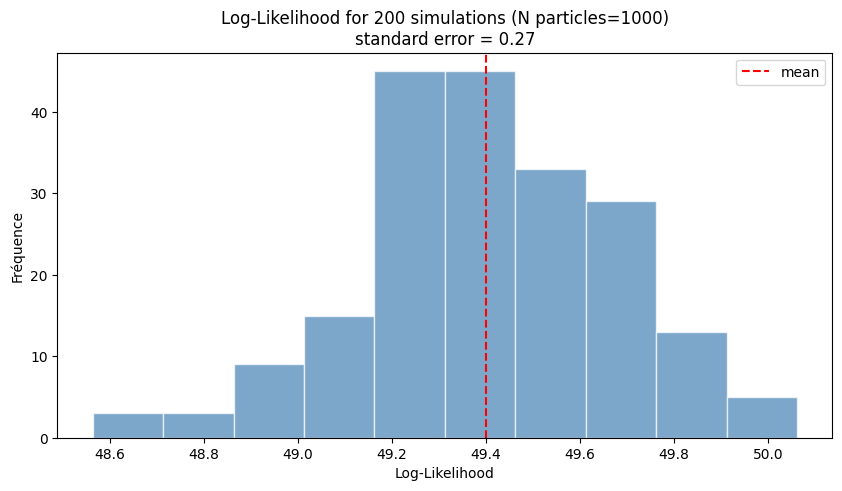

In [72]:
T = 200
n_series = 5
N_particles = 1000
true_params = {'mu': 0.4, 'phi': 0.95, 'sigma': 0.1, 'nu': 5.0}

# génération de données
model_gen = StudentFactorCopulaSSM_U(n_series=n_series, **true_params)
true_states, u_data = simulate_copula_model_U(model_gen, T)
fk = ssm.Bootstrap(ssm=model_gen, data=u_data)

# test stabilité
n_repeats = 200
ll_samples = []

for i in range(n_repeats):
    # On crée un nouveau SMC à chaque run pour voir la variance de Monte-Carlo
    pf = particles.SMC(fk=fk, N=N_particles, verbose=False)
    pf.run()
    ll_samples.append(pf.logLt)
    print(f"Run {i+1}/{n_repeats} : Log-L = {pf.logLt:.2f}")

# Plot
std_ll = np.std(ll_samples)
plt.figure(figsize=(10, 5))
plt.hist(ll_samples, bins=10, alpha=0.7, color='steelblue', edgecolor='white')
plt.axvline(np.mean(ll_samples), color='red', linestyle='--', label='mean')
plt.title(f"Log-Likelihood for {T} simulations (N particles={N_particles})\nstandard error = {std_ll:.2f}")
plt.xlabel("Log-Likelihood")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

Évaluation pour N = 100...
Évaluation pour N = 500...
Évaluation pour N = 1000...
Évaluation pour N = 5000...
Évaluation pour N = 10000...
Évaluation pour N = 20000...


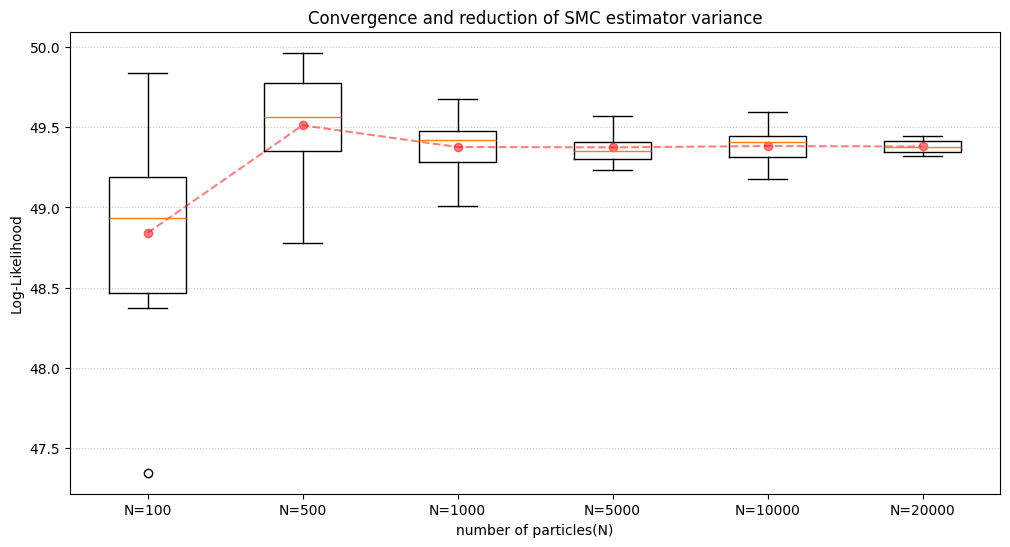

N =  100 | Std Dev = 0.6635 | Moyenne = 48.84
N =  500 | Std Dev = 0.3508 | Moyenne = 49.51
N = 1000 | Std Dev = 0.1755 | Moyenne = 49.38
N = 5000 | Std Dev = 0.1083 | Moyenne = 49.37
N = 10000 | Std Dev = 0.1106 | Moyenne = 49.38
N = 20000 | Std Dev = 0.0384 | Moyenne = 49.38


In [73]:
N_list = [100, 500, 1000, 5000, 10000, 20000]
n_repeats = 10
results = {}

for N in N_list:
    ll_samples = []
    print(f"Évaluation pour N = {N}...")
    for i in range(n_repeats):
        pf = particles.SMC(fk=fk, N=N, verbose=False)
        pf.run()
        ll_samples.append(pf.logLt)
    results[N] = ll_samples

# Plot
plt.figure(figsize=(12, 6))

# On utilise un Boxplot pour montrer la réduction de la variance
data_to_plot = [results[N] for N in N_list]
plt.boxplot(data_to_plot, tick_labels=[f"N={N}" for N in N_list])

# Ajout d'une ligne connectant les moyennes pour voir la stabilisation
means = [np.mean(results[N]) for N in N_list]
plt.plot(range(1, len(N_list) + 1), means, color='red', marker='o', linestyle='--', alpha=0.5, label='Moyenne')

plt.title("Convergence and reduction of SMC estimator variance")
plt.xlabel("number of particles(N)")
plt.ylabel("Log-Likelihood")
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()

# Affichage des écarts-types numériques pour analyse
for N in N_list:
    print(f"N = {N:4d} | Std Dev = {np.std(results[N]):.4f} | Moyenne = {np.mean(results[N]):.2f}")

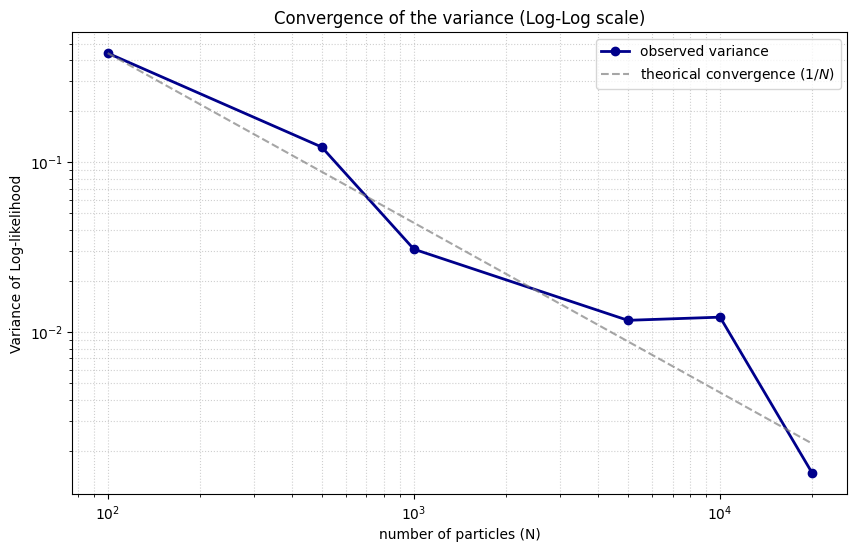

In [74]:
# On s'assure que N_list est trié pour le tracé
sorted_N = sorted(results.keys())
variances = [np.var(results[N]) for N in sorted_N]

# droite théorique : Variance approx C * (1/N)
theoretical_slope = [variances[0] * (sorted_N[0] / n) for n in sorted_N]

# 3. Tracé Log-Log
plt.figure(figsize=(10, 6))

# La courbe empirique (vos résultats)
plt.loglog(sorted_N, variances, 'o-', color='darkblue', lw=2, label='observed variance')

# La courbe théorique
plt.loglog(sorted_N, theoretical_slope, '--', color='gray', alpha=0.7, label='theorical convergence ($1/N$)')

# 4. Habillage
plt.title("Convergence of the variance (Log-Log scale)")
plt.xlabel("number of particles (N)")
plt.ylabel("Variance of Log-likelihood")
plt.grid(True, which="both", ls=":", alpha=0.6)
plt.legend()
plt.show()